In [3]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.model_selection import train_test_split

In [4]:
os.chdir('20240125_dataset_pickle')
files = np.array(os.listdir())
## tous les fichiers
# pickles_files = files[[f.lower().endswith('pickle') for f in files]]
## le premier
pickles_files = files[[f.lower().endswith('pickle') for f in files]][0:1]

In [5]:
# On selectionne, pour tous les dataframes, toutes les colonnes avec les idantifiants, les auteurs et les citations
first = True
for f in pickles_files:
    # import du dataframe
    file = pd.read_pickle(f)
    if first: 
        identifiant = [value for value in file if "identifier" in value] #identifiants
        creators = [value for value in file if "creator" in value] # auteurs
        cites = [value for value in file if "cites" in value] # citations
        cols = identifiant + creators + cites
        data = file[cols] #selection des collones d'interet
        first = False
    else:
        identifiant = [value for value in file if "identifier" in value]
        creators = [value for value in file if "creator" in value]
        cites = [value for value in file if "cites" in value]
        cols = identifiant + creators + cites
        data = pd.concat([data, file[cols]], join = "outer") # concatenation des dataframe
        

In [6]:
def get_domain(index):
    # Extraction de l'ID du domaine
    y = [st[len("http://data.persee.fr/doc/"):st.find("_")] for st in index]
    # Traduction au domaine
    domaines = pd.read_csv("20240141_disciplines.csv", sep = ";")
    return [domaines[domaines.collection_id == yy].Discipline.values[0] for yy in y]

In [7]:
# domaines
y = get_domain(data.index)
print(np.unique(y))

['Archeologie (M.Anc.)' 'Arts (h. art archi.)' 'Droit' 'Etudes classiques'
 'Etudes g. a. cultur.' 'Etudes regionales' 'Geographie…' 'Histoire'
 'Litterature' 'Pluri. Par essence' 'Religion theologie'
 'Science education' 'Science environmnt' 'Science politique'
 'Sciences Terre' 'Sociologie']


In [9]:
# sous ensembles du dataframe en gardant la stratification des classes initiale
data_train, data_test, y_train, y_test = train_test_split(data,
                                                          y,
                                                          train_size = 400,
                                                          test_size=100, 
                                                          stratify = y
                                                         )

In [10]:
def get_edge(df, col_source, col_target):
    graph = nx.Graph()
    graph.add_nodes_from(df.index) # définition des noeuds
    col = [value for value in df.columns if col_target in value] # selection des colonnes contenant le mot cible
    # pour chacune de ces colonnes on regarde si les individus trouvent une correspondance dans la colonne source
    for c in col:
        for i in range(len(col_source)):
            for j in range(len(df)):
                if (i != j) and (col_source[i]==df[c].iloc[j]): 
                    graph.add_edge(df.index[i],df.index[j]) # si correspondance, ajout d'un arc
    return graph

100%|██████████████████████████████████████| 139/139 [6:32:29<00:00, 169.42s/it]


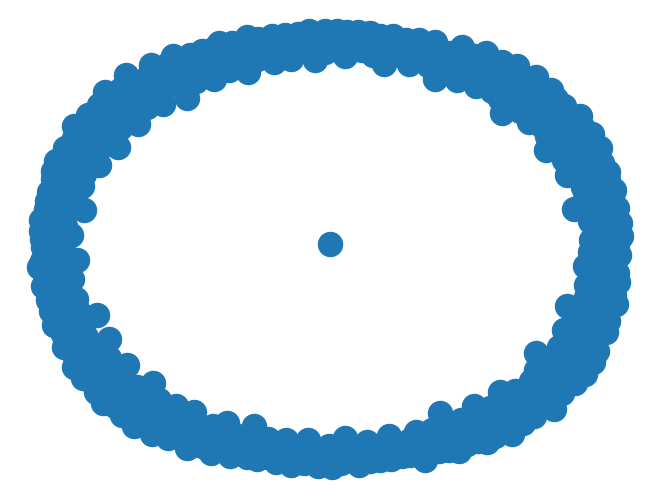

In [11]:
# Graphes de citation
G = nx.Graph()
data_small = pd.concat([data_train, data_test])
# Pour chaque couple de colonnes de citation possible, on cherche les liens entre les documents
for col in tqdm(data_small.columns):
    if "cites" in col: 
        G0 = get_edge(data_small, data_small[col], "cites")
        G = nx.compose(G, G0)
nx.draw(G)

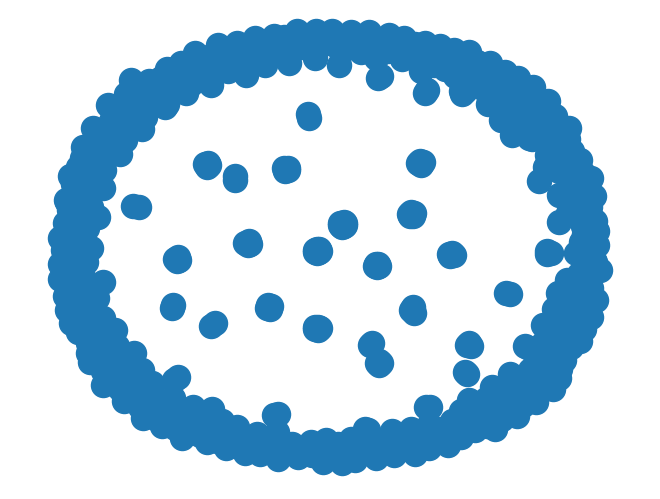

In [12]:
# Graphes d'auteurs
G1 = nx.Graph()
# Pour chaque couple de colonnes d'auteurs possible, on cherche les liens entre les documents
for col in data_small.columns:
    if "creator" in col:
        G2 = get_edge(data_small, data_small[col], "creator")
        G1 = nx.compose(G1, G2)
nx.draw(G1)

In [13]:
# export des graphes
nx.write_gexf(G, "citation.gexf")
nx.write_gexf(G1, "auteur.gexf")

In [14]:
print("Nombre d'arcs : \n")
print(" - Par citations : " + str(len(G.edges)) + "\n")
print(" - Par auteurs : " + str(len(G1.edges)) + "\n")

Nombre d'arcs : 

 - Par citations : 0

 - Par auteurs : 204



In [36]:
# export des données d'interet
data_small["titre"] = file['dcterms:title{Literal}'].loc[data_small.index].values
data_small["domaine"] = np.concatenate([y_train, y_test])
data_small["train"] = [True]*len(y_train) + [False]*len(y_test)
data_small.to_csv("data.csv")